# Logistic Regression
https://realpython.com/logistic-regression-python/

Logistic regression model is based on a sigmoid function that has values very close to either 0 or 1 across most of its domain.
$$\sigma(x) = \frac{1}{1+exp(-x)}$$
The interpretation is that the probability that the output for a given 𝐱 is equal to 1 is
$$p(x) = \sigma(f(x)),$$
where $f(x)$ is a linear function logit
$$f(x) = b_{0}+b_{1}x_{1}+...+b_{r}x_{r}$$
and $b_{i}$ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients. For each observation 𝑖 = 1, …, 𝑛, the predicted output is 1 if 𝑝(𝐱ᵢ) > 0.5 and 0 otherwise. The threshold doesn’t have to be 0.5, but it usually is.
$$ln(\frac{p(𝐱)}{1-p(𝐱)})=f(𝐱)$$
It implies that 𝑝(𝐱) = 0.5 when 𝑓(𝐱) = 0 and that the predicted output is 1 if 𝑓(𝐱) > 0 and 0 otherwise.

In [62]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/Capstone2_CustomerChurn/')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 600)

#### Import `df`

In [63]:
df = pd.read_csv('data/df.csv')
df.head()

,is_churn,city_0,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,discount1_-894.0,discount1_-799.0,discount1_-150.0,discount1_-149.0,discount1_-129.0,discount1_-50.0,discount1_0.0,discount1_20.0,discount1_30.0,discount1_149.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Explanatory and response variables

In [64]:
X = df.drop('is_churn', axis=1) # drop unknown churn
y = df[['is_churn']]
y = np.ravel(y)
y[:5]

array([0, 1, 0, 1, 0], dtype=int64)

#### Quality Metrics

In [143]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

def metrics(y_actual, y_predicted, tn,fp,fn,tp):
    '''Quality Metrics'''
    tnr = tn/(tn + fp) # tnr = 1-fpr
    print(f"TNR = {round(tnr,4)} Specificity, proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp)
    fnr = fn/(tp + fn)
    print(f"FNR = {round(fnr,4)} or Type II Error: Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn)
    accuracy = accuracy_score(y_actual, y_predicted)
    print(f"Accuracy = {round(accuracy,4)}: Percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    print(f"FPR = {round(fpr,4)} Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.")  
    print(f"TPR = {round(tpr,4)} Recall, sensitivity, proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    print(f"Precision = {round(precision_score(y_actual, y_predicted),4)}")
    print(f"F1 score = {round(f1_score(y_actual, y_predicted),4)}: harmonic mean of precision and recall.")
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"MCC = {round(MCC,4)} Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")

#### Training without splitting

In [144]:
# Create and train the Logistic Regression model
model_nosplit = LogisticRegression(random_state=0, solver='lbfgs').fit(X,y)
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}

[[TN, FP], [FN, TP]] =
 [[1565   29]
 [ 115  203]]


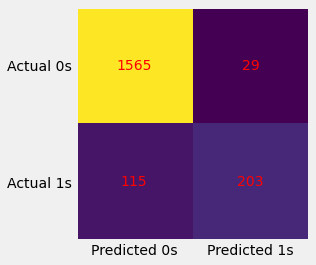

TNR = 0.9818 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.3616 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
Accuracy = 0.9247: Percentage of total items classified correctly
FPR = 0.0182 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.6384 Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.875
F1 score = 0.7382: harmonic mean of precision and recall.
MCC = 0.7072 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.88      0.64      0.74       318

    accuracy                           0.92      1912
   macro avg       0.90      0.81      0.85      1912
weighted avg       0.92      0.92      0.92      1912



In [147]:
y_predicted = model_nosplit.predict(X) # Predicted labels
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y, y_predicted)
metrics(y, y_predicted, tn,fp,fn,tp)
accuracy_nosplit = accuracy_score(y, y_predicted)
print(classification_report(y, y_predicted))

In [135]:
print("Distinct values that y takes:",log_reg_nosplit.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", log_reg_nosplit.predict_proba(X)[:3])
print("Regression Coefficients:\n")
b0_nosplit = log_reg_nosplit.intercept_[0]
print("Intercept b0 =", b0_nosplit)
b_nosplit = log_reg_nosplit.coef_
print("Coefficients b =", b_nosplit)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.90980211 0.09019789]
 [0.02648739 0.97351261]
 [0.99816207 0.00183793]]
Regression Coefficients:

Intercept b0 = 0.36667415078342114
Coefficients b = [[ 2.15377001e-01 -1.11674448e-01 -8.57438214e-02 -8.42375271e-02
   4.64769065e-01  5.59051481e-02 -4.27450553e-01  1.55579041e-01
   2.75652053e-01 -6.50513218e-03 -1.43363528e-01  1.35475691e-01
  -1.87607600e-01  1.12207726e-01  4.26498727e-01  7.60932714e-02
  -1.26886798e-01  9.66553524e-02  4.72198710e-02 -8.88029389e-01
   4.18984720e-01  8.54246569e-02  3.59332515e-01 -2.86796893e-01
  -2.64524718e-01 -1.25432871e+00  4.28689118e-01 -1.04622963e-01
   2.21990652e-01 -4.37947287e-01 -9.31447935e-01 -2.62668196e-01
   7.07313575e-02  4.53934885e-01 -8.76473768e-01 -1.02887960e+00
  -1.81295154e-02 -4.03776028e-01  2.63410611e-01  2.02765977e-01
  -2.65061330e-01 -7.31297219e-02  3.13572832e-01  4.20004459e-01
  -3.73895062e-01  1.16425321e+00 -5.30218115e-01  

#### 3.2.2 Training with splitting
Taking 70% for training set and 30% for test set.

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Train samples:",y_train.shape[0])
print("Test samples:",y_test.shape[0])

Train samples: 1338
Test samples: 574


In [137]:
# Create and train the Logistic Regression model
#solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
log_reg_split = LogisticRegression(solver='saga', random_state=0); # Create a model
log_reg_split.fit(X_train, y_train); # Train model using training set

[[TN, FP], [FN, TP]] =
 [[466  12]
 [ 40  56]]


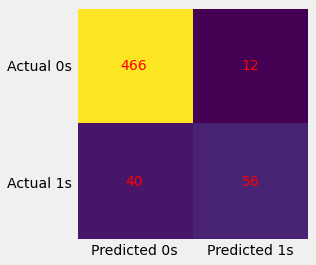

TNR = 0.9749 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4167 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
Accuracy = 0.9094: Percentage of total items classified correctly.
FPR = 0.0251 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.5833 Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8235
F1 score = 0.6829: harmonic mean of precision and recall.
MCC = 0.6447 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       478
           1       0.82      0.58      0.68        96

    accuracy                           0.91       574
   macro avg       0.87      0.78      0.82       574
weighted avg       0.90      0.91      0.90       574



In [139]:
y_pred_split = log_reg_split.predict(X_test) # predicted values
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred_split)
metrics(y_test, y_pred_split, tn,fp,fn,tp)
print(classification_report(y_test, y_pred_split))

In [140]:
print("Distinct values that y takes:",log_reg_split.classes_)
# probability of y=0 (1st column) and y=1 (2nd column)
print("Prediction Probabilities (top):\n", log_reg_split.predict_proba(X_test)[:3])
print("Regression Coefficients:\n")
b0_split = log_reg_split.intercept_[0]
print("Intercept b0 =", b0_split)
b_split = log_reg_split.coef_
print("Coefficients b =", b_split)

Distinct values that y takes: [0 1]
Prediction Probabilities (top):
 [[0.63119671 0.36880329]
 [0.91136894 0.08863106]
 [0.98144419 0.01855581]]
Regression Coefficients:

Intercept b0 = 0.24066827598220575
Coefficients b = [[ 3.05597263e-01  2.61856828e-02 -9.63709755e-02 -3.64636457e-01
   5.80811634e-01 -1.21297472e-01 -5.37201573e-01 -8.25891255e-02
  -3.70422425e-01 -1.70149551e-01 -1.16450388e-01  1.99905228e-01
   6.62278389e-02  2.40990775e-01  4.59984639e-01  0.00000000e+00
   4.94747471e-01 -2.19444927e-02  1.92416848e-01 -6.74603032e-01
   1.62820710e-02  0.00000000e+00  3.25334065e-01 -1.80735487e-01
  -2.80942785e-01 -1.17838088e+00  5.36416023e-01  1.46169080e-01
   3.22162822e-01 -2.47719975e-01 -9.38695154e-01  1.92476781e-01
  -1.69992979e-01  3.86369479e-01 -5.23299515e-01 -6.33645718e-01
  -2.38139415e-01 -2.00020301e-01 -2.52819807e-01  2.16277886e-01
   3.38118253e-02  7.53425895e-02  4.23014070e-01 -1.11612712e-01
  -4.02511329e-01  5.14352180e-01 -1.73302080e-01  

#### Comparison to no split
Quality of the model does not depend on the solver in both cases of no split and 30% test set. Compared to no splitting, many of the model coefficients differ by more than 20%,

In [148]:
print("Intercept relative error:",b0_split/b0_nosplit-1)
print("Coefficient relative error:",b_split/b_nosplit-1)

Intercept relative error: -0.3436453715976333
Coefficient relative error: [[ 4.18894597e-01 -1.23448231e+00  1.23940757e-01  3.32867001e+00
   2.49677912e-01 -3.16970130e+00  2.56757229e-01 -1.53084995e+00
  -2.34380434e+00  2.51562020e+01 -1.87726548e-01  4.75580060e-01
  -1.35301256e+00  1.14771998e+00  7.85135081e-02 -1.00000000e+00
  -4.89912487e+00 -1.22703857e+00  3.07491260e+00 -2.40337042e-01
  -9.61139225e-01 -1.00000000e+00 -9.46155669e-02 -3.69813653e-01
   6.20662851e-02 -6.05485849e-02  2.51293770e-01 -2.39710324e+00
   4.51244992e-01 -4.34361207e-01  7.78059499e-03 -1.73277536e+00
  -3.40336091e+00 -1.48843829e-01 -4.02949028e-01 -3.84140072e-01
   1.21354540e+01 -5.04625616e-01 -1.95979356e+00  6.66379476e-02
  -1.12756227e+00 -2.03025948e+00  3.49013776e-01 -1.26574173e+00
   7.65355586e-02 -5.58212787e-01 -6.73149455e-01 -2.40544386e-01
   9.57765156e-01  5.41123928e+00  2.05683510e+00  5.85796553e-02
  -1.02715717e-02 -1.12231321e-01 -1.85300971e-01  1.05314916e-01
  

<ipython-input-148-69d93c4e9c82>:2: RuntimeWarning: invalid value encountered in true_divide
  print("Coefficient relative error:",b_split/b_nosplit-1)


and all quality metrics are considerably worse than for no split (Accuracy is 1.65% lower, FPR is 37.9% higher, TPR is 8.69% lower, Precision is 5.89% lower, F1 score is 7.49% lower, and MCC is 8.84% lower).

In [149]:
print("Relative difference in accuracy =", accuracy_split/accuracy_nosplit-1)

Relative difference in accuracy = -0.01652293187443843


The change in the proportion of positive values 1 of the label `is_churn` in the test dataset compared to the full dataset is only 0.56%,

In [150]:
print("Proportion of `is_churn==1` in the full set:", np.sum(y)/len(y))

Proportion of `is_churn==1` in the full set: 0.16631799163179917


In [151]:
print("Proportion of `is_churn==1` in the test set:", np.sum(y_test)/len(y_test))

Proportion of `is_churn==1` in the test set: 0.1672473867595819


so this is not the reason for the large reduction in model quality.

#### 3.2.3 Optimization of the regularization parameter C
Let's try to adjust the regularization strength C.

In [152]:
def opt_C(Cmin,Cmax,Cstep):
    '''Optimize regularization parameter C by maximizing accuracy in Logistic Regression for Train-Test split.'''
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_C = LogisticRegression(C=C, random_state=0, max_iter=3000)
        log_reg_C.fit(X_train, y_train)
        pred = log_reg_C.predict(X_test) # predicted values
        acc = log_reg_C.score(X_test, y_test) # proportion of correct predictions
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

Optimal C = 0.4
Highest accuracy = 0.9094076655052264


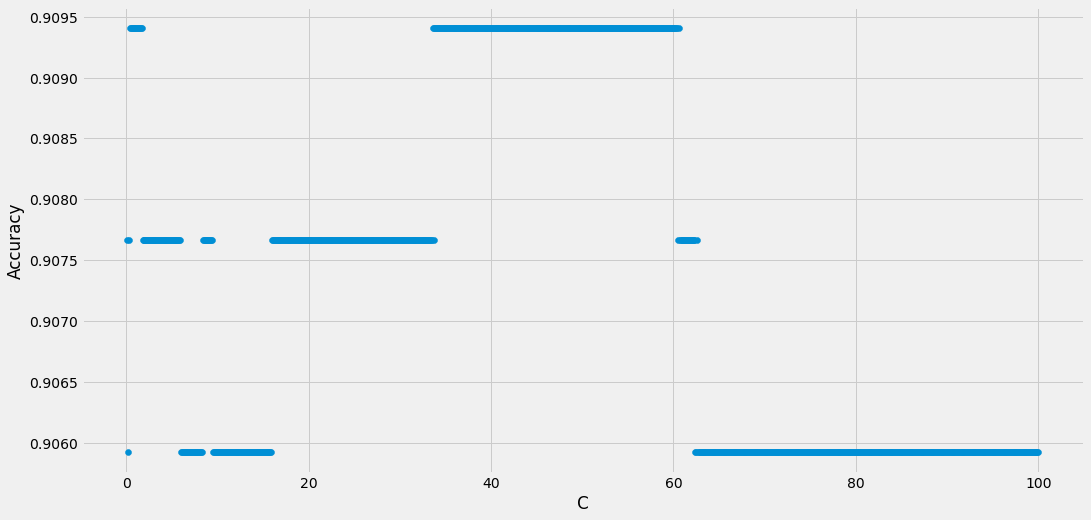

In [153]:
opt_C(0.1,100,0.1)

Optimal C = 0.4
Highest accuracy = 0.9094076655052264


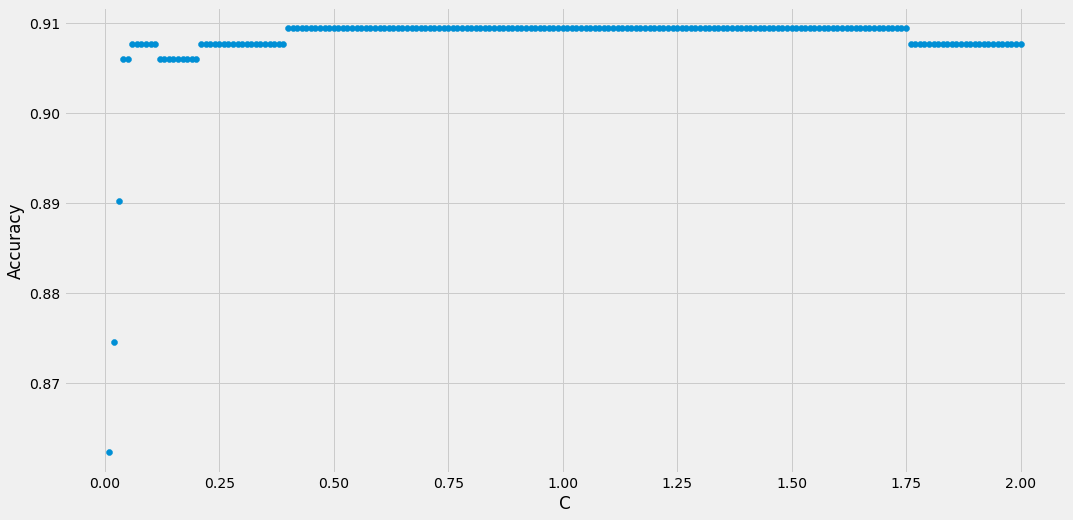

In [154]:
opt_C(0.01,2,0.01)

Optimized C in Logistic Regression with 30% test split:
Accuracy = 0.9094076655052264
[[TN, FP], [FN, TP]] =
 [[466  12]
 [ 40  56]]


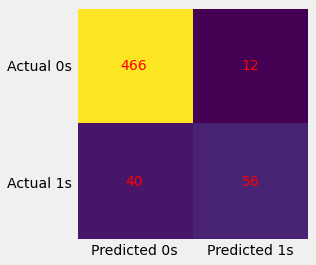

TNR = 0.9749 Specificity, proportion of the negative class 0 got correctly classified.
FNR = 0.4167 or Type II Error: Proportion of the positive class 1 got incorrectly classified.
Accuracy = 0.9094: Percentage of total items classified correctly
FPR = 0.0251 Specificity, or Type I Error: proportion of the negative class 0 got incorrectly classified.
TPR = 0.5833 Recall, sensitivity, proportion of the positive class 1 got correctly classified.
Precision = 0.8235
F1 score = 0.6829: harmonic mean of precision and recall.
MCC = 0.6447 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1594
           1       0.88      0.64      0.74       318

    accuracy                           0.92      1912
   macro avg       0.90      0.81      0.85      1912
weighted avg       0.92      0.92      0.92      1912



In [155]:
print('Optimized C in Logistic Regression with 30% test split:')
C_opt = 1.0
log_reg_C = LogisticRegression(C=C_opt, random_state=0).fit(X_train, y_train) # Create and train model using training set
pred_C = log_reg_C.predict(X_test) # predicted values
print("Accuracy =",log_reg_C.score(X_test, y_test)) # proportion of correct predictions
tn,fp,fn,tp = confusion_matrix_plot(y_test, pred_C)
metrics(y_test, pred_C, tn,fp,fn,tp)
print(classification_report(y, y_predicted))

Optimization of the regularization parameter 'C' did not lead to an improvement in accuracy, since the accuracy and other performance metrics stay same for $C \in [0.392, 1.756]$. A way to increase recall is to adjust the threshold probability, which will be done below when considering ROC and Precision-Recall curves.

#### Cross-Validation
A more reliable way of validating the model and optimizing its parameters is by cross-validation.

In [156]:
from sklearn.model_selection import cross_val_score
print("Example of cross-validation:")
log_reg_cv = LogisticRegression(random_state=0) #solver='liblinear'
scores = cross_val_score(log_reg_cv, X, y, cv=10) #X_train, y_train
print('Cross-Validation Accuracy Scores', scores)
scores.min(), scores.mean(), scores.max()

Example of cross-validation:
Cross-Validation Accuracy Scores [0.96354167 0.921875   0.91099476 0.91623037 0.89005236 0.88481675
 0.93193717 0.87434555 0.90052356 0.91623037]


(0.8743455497382199, 0.9110547556719023, 0.9635416666666666)

In [ ]:
?LogisticRegression

In [157]:
def optCV_C(Cmin,Cmax,Cstep):
    '''Optimize regularization parameter C in Logistic Regression with 10-fold Cross-Validation'''
    accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
    acc_opt = 0
    for C in np.arange(Cmin, Cmax+Cstep, Cstep):
        log_reg_cv = LogisticRegression(solver='lbfgs', C=C, max_iter=3000, random_state=0) #liblinear
        scores = cross_val_score(log_reg_cv, X, y, cv=10) # accuracies of cv cross-validations
        acc = scores.mean()
        accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
        if acc_opt < acc:
            acc_opt = acc
            C_opt = C
    print('Optimal C =',C_opt)
    print('Highest accuracy =',acc_opt)
    fig, axs = plt.subplots(figsize = (16,8))
    plt.scatter(accuracy['C'],accuracy['Accuracy']);
    plt.xlabel('C');
    plt.ylabel('Accuracy');

In [ ]:
INSERT FROM 2nd FILE

Optimize regularization parameter C using cross-validation
Optimal C = 0.04
Highest accuracy = 0.9126553944058013


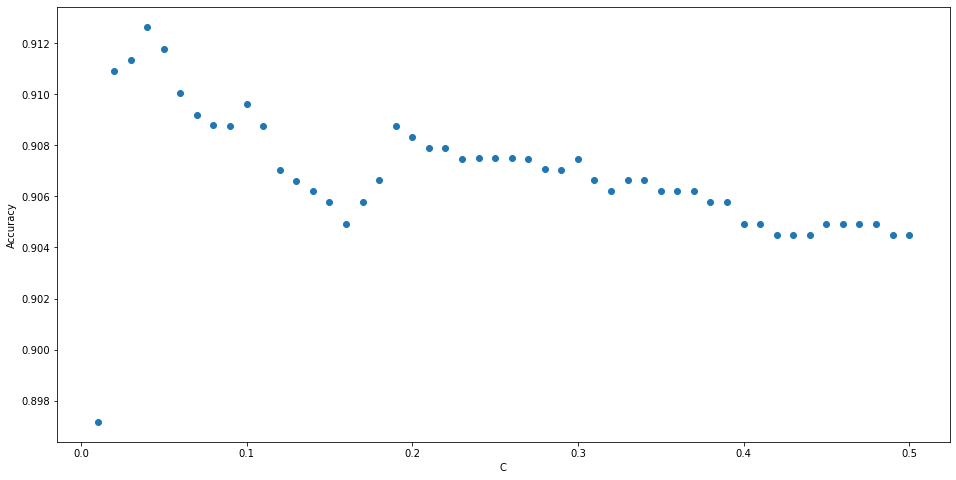

In [41]:
print('Detailed optimization')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.01, 0.51, 0.01):
    C = round(C,2)
    log_reg = LogisticRegression(solver='liblinear', C=C, random_state=0)
    scores = cross_val_score(log_reg, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
fig, axs = plt.subplots(figsize = (16,8))
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

Optimize regularization parameter C using cross-validation
Optimal C = 0.044
Highest accuracy = 0.9130845789551577


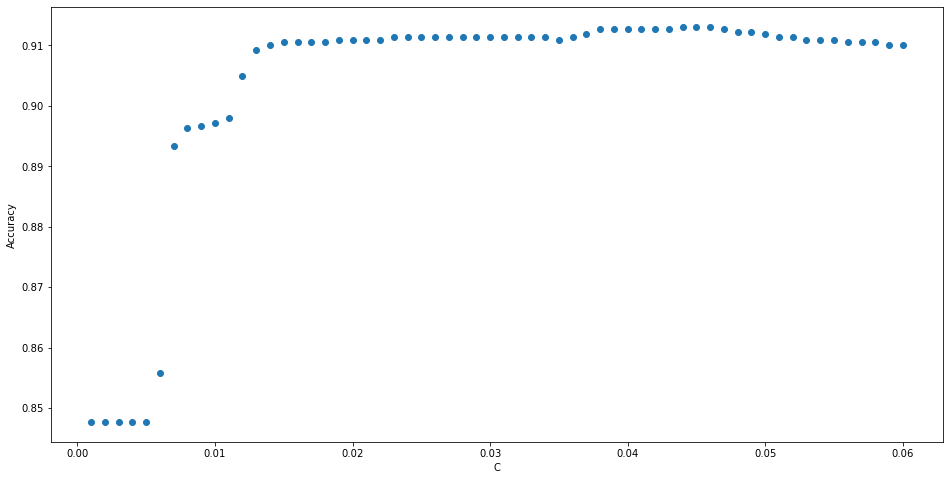

In [43]:
print('Detailed optimization')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.001, 0.061, 0.001):
    C = round(C,3)
    log_reg = LogisticRegression(solver='liblinear', C=C, random_state=0)
    scores = cross_val_score(log_reg, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
fig, axs = plt.subplots(figsize = (16,8))
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

### Quality metrics

Optimized C in Logistic Regression with 10-fold Cross-Validation:
Accuracy = 0.9146586345381527
[[TN, FP], [FN, TP]] =
 [[844   9]
 [ 76  67]]


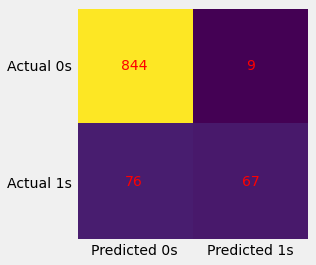

In [49]:
C_opt=0.044
print('Optimized C in Logistic Regression with 10-fold Cross-Validation:')
log_reg = LogisticRegression(solver='liblinear', C=C_opt, random_state=0) # Create a model
log_reg.fit(X_train, y_train) # Train model using training set
y_pred = log_reg.predict(X_test) # predicted values
print("Accuracy =",log_reg.score(X_test, y_test)) # proportion of correct predictions
tn,fp,fn,tp = confusion_matrix_plot(y_test, y_pred)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       853
         1.0       0.88      0.47      0.61       143

    accuracy                           0.91       996
   macro avg       0.90      0.73      0.78       996
weighted avg       0.91      0.91      0.90       996



In [52]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print('Recall =', recall_score(y_test, pred_cv))
# tpr = tp/(tp + fn) Recall, sensitivity, proportion of the positive class 1 got correctly classified.
print('Precision =', precision_score(y_test, pred_cv))
print('F1 score =', f1_score(y_test, pred_cv))
fnr = fn/(tp + fn)
print(f"FNR = {round(fnr,4)} Proportion of the positive class 1 got incorrectly classified.")
tnr = tn/(tn + fp)
print(f"TNR = {round(tnr,4)} Specificity, proportion of the negative class 0 got correctly classified.")
fpr = fp/(tn + fp)
print(f"FPR = {round(fpr,4)} Specificity, proportion of the negative class 0 got incorrectly classified.")
MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(f"MCC = {round(MCC,4)} Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")

Recall = 0.46853146853146854
Precision = 0.881578947368421
F1 score = 0.6118721461187215
FNR = 0.5315 Proportion of the positive class 1 got incorrectly classified.
TNR = 0.9894 Specificity, proportion of the negative class 0 got correctly classified.
FPR = 0.0106 Specificity, proportion of the negative class 0 got incorrectly classified.
MCC = 0.6049 Matthews correlation coefficient: accounts for all 4 confusion matrix categories.


### ROC - AUC, Optimization of classification threshold
Area Under the Curve (AUC) of Receiver Characteristic Operator (ROC) helps us visualize how well our machine learning classifier is performing and choose the optimal classification threshold probability.

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

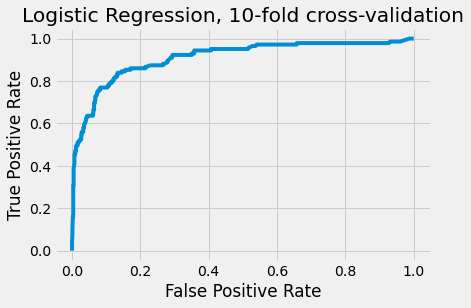

AUC: 0.910


In [47]:
prob_y = log_reg_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_y, pos_label=1, drop_intermediate=False)
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title('Logistic Regression, 10-fold cross-validation')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend() # show the legend
plt.show()
print('AUC: %.3f' % roc_auc_score(y_test, prob_y))

Manual ROC curve with controllable no. of threshold probabilities.

FPR = [1.         1.         1.         0.9144197  0.57327081 0.41031653
 0.38569754 0.36694021 0.35756155 0.35756155 0.35287222 0.34818288
 0.33177022 0.30715123 0.28956624 0.23446659 0.1852286  0.16178195
 0.13716295 0.11957796 0.10433763 0.09378664 0.08675264 0.07737397
 0.07620164 0.07385698 0.07385698 0.07385698 0.07268464 0.06799531
 0.06565064 0.06447831 0.06213365 0.06096131 0.05275498 0.04454865
 0.03634232 0.03282532 0.02813599 0.02344666 0.01875733 0.01641266
 0.01289566 0.01289566 0.01289566 0.01172333 0.01172333 0.01172333
 0.010551   0.010551   0.010551   0.00937866 0.00937866 0.00937866
 0.00937866 0.00937866 0.00937866 0.00937866 0.00820633 0.00820633
 0.00820633 0.00820633 0.00820633 0.00820633 0.00820633 0.00820633
 0.00820633 0.007034   0.007034   0.007034   0.007034   0.007034
 0.007034   0.00468933 0.00468933 0.00468933 0.00468933 0.00234467
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.    

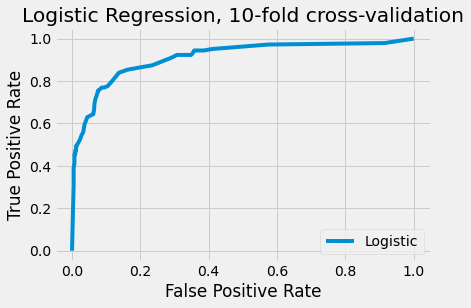

AUC: 0.910


In [45]:
pred_prob = log_reg.predict_proba(X_test) # probability of y=0 (1st column) and y=1 (2nd column)
prob_step = 0.01
fpr = np.empty(int(1+1/prob_step))
tpr = np.empty(int(1+1/prob_step))
j = 0 # counter of points
thresholds = np.arange(0, 1+prob_step, prob_step)
for prob_thresh in thresholds:
    tn = 0; fn = 0; tp = 0; fp = 0;
    for i in range(pred_prob.shape[0]): # each test case
        if pred_prob[i,1] >= prob_thresh: # classify as 1
            if y_test[i] == 0: # actual 0
                fp = fp+1
            else: # actual 1
                tp = tp+1
        else: # classify as 0
            if y_test[i] == 0: # actual 0
                tn = tn+1
            else: # actual 1
                fn = fn+1
    fpr[j] = fp/(tn + fp) # specificity
    tpr[j] = tp/(tp + fn) # sensitivity
    j = j+1
print("FPR =",fpr)
print("TPR =",fpr)
# ROC curve
plt.plot(fpr, tpr, linestyle='-', label='Logistic')
plt.title('Logistic Regression, 10-fold cross-validation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() # show the legend
plt.show()
print('AUC: %.3f' % roc_auc_score(y_test, pred_prob[:,1]))

In [39]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = 0.5
preds = np.where(log_reg_cv.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.914659
recall,0.468531
precision,0.881579
roc_auc_score,0.728990


### Optimize decision threshold

In [41]:
# calculate the squared g-mean for each threshold
gmeans_sq = tpr*(1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.4f, G-Mean_sq=%.4f' % (thresh[ix], gmeans_sq[ix]))
print('FPR=%.4f, TPR=%.4f' % (fpr[ix], tpr[ix]))

from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = thresh[ix]
preds = np.where(log_reg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

Best Threshold=0.7155, G-Mean_sq=0.7241
FPR=0.1372, TPR=0.8392


,0
accuracy,0.909639
recall,0.412587
precision,0.907692
roc_auc_score,0.702777


### Optimize solver

Optimize C using 10-fold cross-validation, lbfgs solver
Optimal C = 0.1
Highest accuracy = 0.9087760840609738


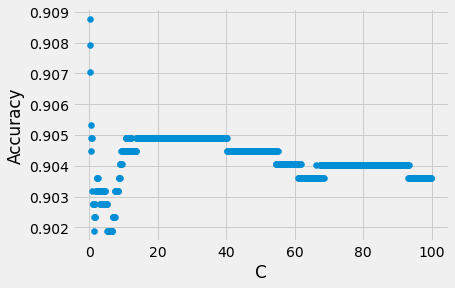

In [42]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.1, 100.0, 0.1):
    C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    #if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

In [ ]:
print('Optimize C using 10-fold cross-validation, lbfgs solver')
log_reg_lbfgs = LogisticRegression(solver='lbfgs')
accuracy = pd.DataFrame({'C':[],'Accuracy':[]})
acc_opt = 0
for C in np.arange(0.01, 10.01, 0.01):
    #C = round(C,1)
    log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C, random_state=0, max_iter=3000)
    scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
    acc = scores.mean()
    accuracy = accuracy.append({'C':C,'Accuracy':acc}, ignore_index=True)
    if acc_opt < acc:
        acc_opt = acc
        C_opt = C
    #if C % 10 == 0: print("C =",C)
print('Optimal C =',C_opt)
print('Highest accuracy =',acc_opt)
plt.scatter(accuracy['C'],accuracy['Accuracy']);
plt.xlabel('C');
plt.ylabel('Accuracy');

Optimize C using 10-fold cross-validation, lbfgs solver


In [120]:
C_opt=0.04
log_reg_cv_lbfgs = LogisticRegression(solver='lbfgs', C=C_opt, random_state=0, max_iter=3000)
log_reg_cv_lbfgs.fit(X_test, y_test)
scores = cross_val_score(log_reg_cv_lbfgs, X_train, y_train, cv=10) # accuracies of cv cross-validations
acc = scores.mean()
print("Accuracy =",acc)
prob_cv_lbfgs = log_reg_cv_lbfgs.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, prob_cv_lbfgs, pos_label=1, drop_intermediate=False)

Accuracy = 0.9126553944058013


In [121]:
### Optimize decision threshold
# calculate the squared g-mean for each threshold
gmeans_sq = tpr*(1-fpr)
# locate the index of the largest g-mean
ix = np.argmax(gmeans_sq)
print('Best Threshold=%.4f, G-Mean_sq=%.4f' % (thresh[ix], gmeans_sq[ix]))
print('FPR=%.4f, TPR=%.4f' % (fpr[ix], tpr[ix]))

from sklearn.metrics import accuracy_score, recall_score, precision_score
THRESHOLD = thresh[ix]
preds = np.where(log_reg_cv.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

Best Threshold=0.1697, G-Mean_sq=0.6975
FPR=0.1688, TPR=0.8392


,0
accuracy,0.838353
recall,0.853147
precision,0.465649
roc_auc_score,0.844510
